In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 
import scipy

In [56]:
datagen_kwargs = dict(rescale=1./255, validation_split=.80)

In [57]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
'./test dataset/',
subset="validation",
shuffle=True,
target_size=(224,224)
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
 './test dataset/',
subset="validation",
shuffle=True,
target_size=(224,224))

Found 2950 images belonging to 40 classes.
Found 2950 images belonging to 40 classes.


In [58]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)

In [59]:
model = tf.keras.Sequential([
 hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
 output_shape=[1280],
 trainable=False),
 tf.keras.layers.Dropout(0.4),
 tf.keras.layers.Dense(train_generator.num_classes, activation="softmax")
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 40)                51240     
                                                                 
Total params: 2309224 (8.81 MB)
Trainable params: 51240 (200.16 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [60]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(
 optimizer=optimizer,
 loss="categorical_crossentropy",
 metrics=['acc'])

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
 train_generator, 
 epochs=20,
 verbose=1,
 steps_per_epoch=steps_per_epoch,
 validation_data=valid_generator,
 validation_steps=val_steps_per_epoch).history

In [ ]:
test_loss, test_accuracy = model.evaluate(train_generator )
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
model.save('my_model.h5')

In [ ]:
# final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
# print("Final loss: {:.2f}".format(final_loss))
# print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
print(hist)

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

In [ ]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

In [67]:
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np

In [ ]:
image_path = 'test.jpg'
image = cv2.imread(image_path)  # Use cv2.imread to read the image
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
tf_model_predictions = model.predict(valid_generator)
print("Prediction results shape:", tf_model_predictions.shape)
print(tf_model_predictions)

In [69]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Betel' 'Eucalyptus' 'Ginger' ... 'Coriender' 'Guava' 'Coriender']


ValueError: num must be an integer with 1 <= num <= 30, not 31

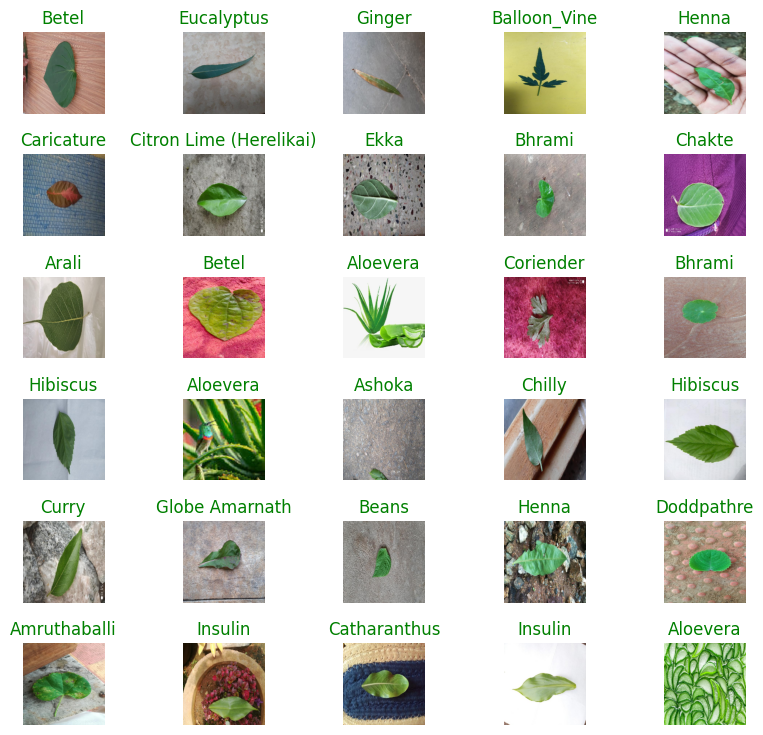

In [70]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [51]:
# Calculate the number of rows and columns for subplots
num_images = len(predicted_labels)
num_rows = (num_images - 1) // 5 + 1
num_cols = min(num_images, 5)


